In [1]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pickle
from datetime import datetime
from sklearn.metrics import ConfusionMatrixDisplay
from ipynb.fs.defs.Prepare_Data import train_test_val
from ipynb.fs.defs.Prepare_Data import load_csv_into_df
from ipynb.fs.defs.Prepare_Data import combine_dataframes
from ipynb.fs.defs.Prepare_Data import clean_text
from ipynb.fs.defs.Feature_Engineering import preprocess_dataset
from ipynb.fs.defs.Data_Augmentation import data_augmentation
from config import lgbm_params
from config import lgbm_hyperparameter as lgbm_hp
import pandas as pd
import random
import matplotlib.pyplot as plt
from ipynb.fs.defs.Prepare_Data import train_test_val_kfold
from sklearn.model_selection import KFold

In [2]:
def get_vocabulary(column):
    text = ' '.join(column.astype(str))
    words = text.upper().split()
    word_counts = pd.Series(words).value_counts()
    vocabulary = word_counts.index.tolist()

    return vocabulary

In [18]:
def store_predictions(model, X_test, y_test, y_pred, probs, features, timestamp):
    vectorizer_path = f"../models/lgbm_{timestamp}/vectorizer.pkl"
    # Load the vectorizer from the file
    with open(vectorizer_path, 'rb') as f:
        vectorizer = pickle.load(f)

    vocabulary_path = f"../models/lgbm_{timestamp}/vocabulary.pkl"
    # Get the vocabulary of the training data
    with open(vocabulary_path, 'rb') as f:
        vocabulary = pickle.load(f)
        
    # Extrahieren der wichtigsten Features
    boost = model.booster_
    importance = boost.feature_importance()
    feature_names = boost.feature_name()
    sorted_idx = np.argsort(importance)[::-1]

    feature_dict = {vocabulary.shape[0]+index: key for index, key in enumerate(features)}

    true_label = y_test.reset_index(drop=True)

    X_test_restored = vectorizer.inverse_transform(X_test[:,:vocabulary.shape[0]-len(features)])
    original_designation = [' '.join(words) for words in X_test_restored]

    print('Wichtigsten Features:')
    for j in sorted_idx:
        if importance[j] > 100:
            if j < vocabulary.shape[0]:
                print('{} ({}) Value: {}'.format(feature_names[j], importance[j], vocabulary[j]))
            else:
                print('{} ({}) Value: {}'.format(feature_names[j], importance[j], feature_dict[j]))
        else:
            continue

    # Ausgabe der Vorhersagen, der Wahrscheinlichkeiten und der wichtigsten Features
    for i in range(len(X_test)):
        if y_pred[i] != true_label[i]:
            print('Vorhersage für Sample {}: {}'.format(i+1, y_pred[i]), 'True: {}'.format(true_label[i]))
            print(original_designation[i])

            print('Wahrscheinlichkeit für Sample {}: {}'.format(i+1, probs[i][1]))

            print('------------------------')

In [4]:
def load_prepare_dataset(folder_path, only_text, augmentation, kfold):
    dataframes_list = load_csv_into_df(folder_path, original_prisma_data=False, move_to_archive=False)

    # Take random dataset from list as test set and drop it from the list
    random_index = random.randint(0, len(dataframes_list) - 1)
    df_test = dataframes_list[random_index]
    dataframes_list.pop(random_index)

    df_combined = combine_dataframes(dataframes_list)
    df_preprocessed, df_for_plot = preprocess_dataset(df_combined, cut_percent_of_front=lgbm_params["cut_percent_of_front"])
    df_test, df_test_for_plot = preprocess_dataset(df_test, cut_percent_of_front=lgbm_params["cut_percent_of_front"])

    df_preprocessed = clean_text(df_preprocessed)
    df_test = clean_text(df_test)

    df_preprocessed.to_excel("df_preprocessed.xlsx")
    df_test.to_excel("df_test.xlsx")

    vocab = get_vocabulary(df_preprocessed['Benennung (dt)'])

    if augmentation:
        # Declare which data augmentation techniques should be used
        rand_order = True
        rand_mistakes = True
        gpt = True

        # Generate the new dataset
        df_preprocessed = data_augmentation(df_preprocessed, rand_order, rand_mistakes, gpt, df_to_excel = False)
        df_preprocessed.to_excel("augmented_data.xlsx")

    weight_factor = round(df_preprocessed[df_preprocessed["Relevant fuer Messung"]=="Nein"].shape[0] / df_preprocessed[df_preprocessed["Relevant fuer Messung"]=="Ja"].shape[0])

    dateTimeObj = datetime.now()
    timestamp = dateTimeObj.strftime("%d%m%Y_%H%M")

    # Split dataset
    if kfold:
        X, y, X_test, y_test, features = train_test_val_kfold(df_preprocessed, df_test, only_text, test_size=lgbm_params["test_size"], timestamp=timestamp)
        return X, y, X_test, y_test, features, weight_factor, timestamp, vocab
    else:
        X_train, y_train, X_val, y_val, X_test, y_test, features = train_test_val(df_preprocessed, df_test, test_size=lgbm_params["test_size"], timestamp=timestamp)
        return X_train, y_train, X_val, y_val, X_test, y_test, features, weight_factor, timestamp, vocab

In [5]:
def train_model(X_train, y_train, X_val, y_val, weight_factor):
    
    class_weight = {0: 1, 1: weight_factor}
    evals = {}
    callbacks = [lgb.early_stopping(lgbm_params["early_stopping"]), lgb.record_evaluation(evals)]

    gbm = LGBMClassifier(boosting_type='dart',
                        objective='binary',
                        metric=['auc', 'binary_logloss'],
                        num_leaves=lgbm_hp["num_leaves"],
                        max_depth=lgbm_hp["max_depth"],
                        learning_rate=0.15,
                        feature_fraction=lgbm_hp["feature_fraction"],
                        n_estimators=lgbm_params["n_estimators"],
                        class_weight=class_weight)

    gbm.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)], 
            eval_metric=lgbm_params["metrics"],
            early_stopping_rounds=lgbm_params["early_stopping"],
            callbacks=callbacks)

    
    return gbm, evals

In [6]:
def store_trained_model(model, test_acc, timestamp):
    # save model
    model_path = f"../models/lgbm_{timestamp}/model_{str(test_acc)[2:]}.pkl"
    with open(model_path, "wb") as filestore:
        pickle.dump(model, filestore)

In [7]:
def evaluate_model(model, X_test, y_test, evals, timestamp):
    threshold = 0.50
    probs = model.predict_proba(X_test)
    y_pred = (probs[:,1] >= threshold)
    y_pred =  np.where(y_pred, 1, 0) 

    # Print accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    print("\n\n Test accuracy:", accuracy, "\n\n")

    lgb.plot_metric(evals, metric='binary_logloss')
    plt.savefig(f'../models/lgbm_{timestamp}/binary_logloss_plot.png')

    lgb.plot_metric(evals, metric='auc')
    plt.savefig(f'../models/lgbm_{timestamp}/auc_plot.png')

    class_names = ["Nein", "Ja"]
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=class_names, cmap='Blues', colorbar=False)
    plt.savefig(f'../models/lgbm_{timestamp}/confusion_matrix.png')

    return y_pred, probs, accuracy

In [19]:
# Split dataset
folder_path = "../data/labeled_data/"
X_train, y_train, X_val, y_val, X_test, y_test, features, weight_factor, timestamp, vocab = load_prepare_dataset(folder_path, only_text=True, augmentation=False, kfold=False)


2023-05-22 17:07:35.342 | INFO     | ipynb.fs.defs.Prepare_Data:load_csv_into_df:34 - Loading the data...
2023-05-22 17:07:52.133 | SUCCESS  | ipynb.fs.defs.Prepare_Data:load_csv_into_df:67 - 8 dataframe(s) were created.
2023-05-22 17:07:52.145 | SUCCESS  | ipynb.fs.defs.Prepare_Data:combine_dataframes:89 - 7 dataframe(s) are combined to one dataset.
2023-05-22 17:07:52.146 | INFO     | ipynb.fs.defs.Feature_Engineering:preprocess_dataset:199 - Start preprocessing the dataframe with 21371 samples...
2023-05-22 17:08:10.620 | SUCCESS  | ipynb.fs.defs.Feature_Engineering:preprocess_dataset:258 - The dataset is successfully preprocessed. The new dataset contains 3266 samples
2023-05-22 17:08:10.627 | INFO     | ipynb.fs.defs.Feature_Engineering:preprocess_dataset:199 - Start preprocessing the dataframe with 2394 samples...
2023-05-22 17:08:12.665 | SUCCESS  | ipynb.fs.defs.Feature_Engineering:preprocess_dataset:258 - The dataset is successfully preprocessed. The new dataset contains 579 s

c:\Users\q617269\AppData\Local\anaconda3\envs\envMesstool\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


c:\Users\q617269\AppData\Local\anaconda3\envs\envMesstool\lib\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')




 Test accuracy: 0.9879101899827288 


Wichtigsten Features:
Column_60346 (4143) Value: center_x
Column_60348 (4046) Value: center_z
Column_60347 (3441) Value: center_y
Column_60350 (3441) Value: width
Column_60349 (3282) Value: length
Column_60351 (3277) Value: height
Column_60352 (940) Value: theta_x
Column_7461 (789) Value: ante
Column_50512 (441) Value: stf
Column_18128 (426) Value: en h
Column_9860 (395) Value: bezu
Column_39947 (351) Value: nst
Column_30783 (345) Value: kl 
Column_3159 (312) Value:  oben
Column_18035 (295) Value: en 
Column_52512 (275) Value: ten
Column_13240 (246) Value: dec
Column_40065 (223) Value: nte
Column_40752 (221) Value: obe
Column_5538 (220) Value: abd
Column_18758 (219) Value: enha
Column_9862 (217) Value: bezug 
Column_60353 (213) Value: theta_y
Column_8801 (208) Value: aussenh
Column_60354 (206) Value: theta_z
Column_52787 (204) Value: ter
Column_52016 (202) Value: te 
Column_15717 (193) Value: eck
Column_1769 (193) Value:  hi
Column_30323 (182) Va

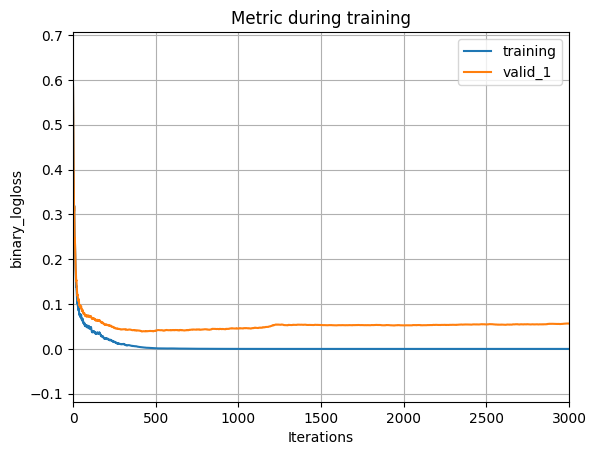

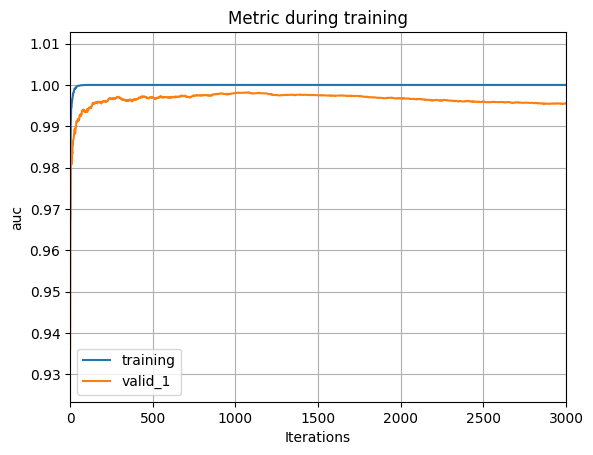

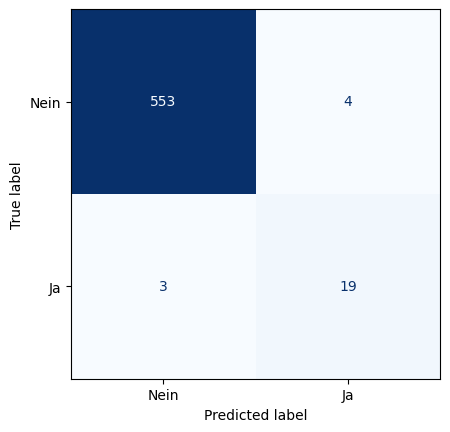

In [20]:
store_model = False
show_preds = True

gbm, evals = train_model(X_train, y_train, X_val, y_val, weight_factor)
y_pred, probs, test_acc = evaluate_model(gbm, X_test, y_test, evals, timestamp)

if show_preds:
    store_predictions(gbm, X_test, y_test, y_pred, probs, features, timestamp)

if store_model:
    store_trained_model(gbm, test_acc, timestamp)


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

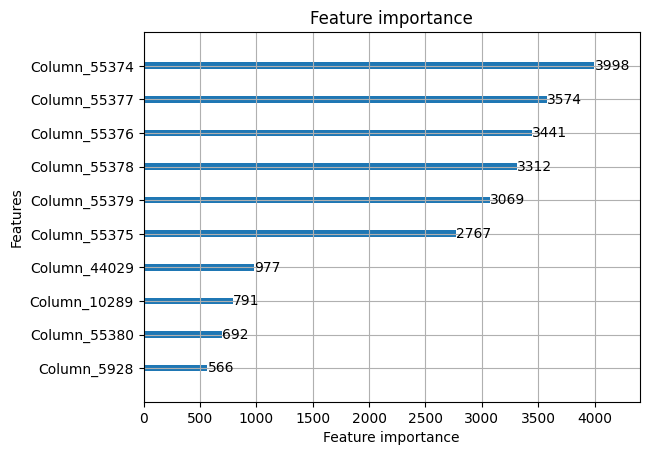

In [10]:
from lightgbm import plot_importance
plot_importance(gbm, max_num_features=10)

## K-fold Crossvalidation

2023-05-16 16:22:10.666 | INFO     | ipynb.fs.defs.Prepare_Data:load_csv_into_df:34 - Loading the data...
2023-05-16 16:22:17.107 | SUCCESS  | ipynb.fs.defs.Prepare_Data:load_csv_into_df:67 - 8 dataframe(s) were created.
2023-05-16 16:22:36.263 | SUCCESS  | ipynb.fs.defs.Prepare_Data:combine_dataframes:90 - 7 dataframe(s) are combined to one dataset and stored in a excel file.
2023-05-16 16:22:36.265 | INFO     | ipynb.fs.defs.Feature_Engineering:preprocess_dataset:199 - Start preprocessing the dataframe with 20715 samples...
2023-05-16 16:22:50.833 | SUCCESS  | ipynb.fs.defs.Feature_Engineering:preprocess_dataset:255 - The dataset is successfully preprocessed. The new dataset contains 3523 samples
2023-05-16 16:22:50.835 | INFO     | ipynb.fs.defs.Feature_Engineering:preprocess_dataset:199 - Start preprocessing the dataframe with 3050 samples...
2023-05-16 16:22:53.061 | SUCCESS  | ipynb.fs.defs.Feature_Engineering:preprocess_dataset:255 - The dataset is successfully preprocessed. The

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Training until validation scores don't improve for 30 rounds


 Test accuracy: 0.968 




c:\Users\q617269\AppData\Local\anaconda3\envs\envMesstool\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Training until validation scores don't improve for 30 rounds


 Test accuracy: 0.986 




c:\Users\q617269\AppData\Local\anaconda3\envs\envMesstool\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Training until validation scores don't improve for 30 rounds


 Test accuracy: 0.974 




c:\Users\q617269\AppData\Local\anaconda3\envs\envMesstool\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Training until validation scores don't improve for 30 rounds


 Test accuracy: 0.954 




c:\Users\q617269\AppData\Local\anaconda3\envs\envMesstool\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[92]	training's auc: 0.952744	training's binary_logloss: 0.516879	valid_1's auc: 0.916388	valid_1's binary_logloss: 0.545903


 Test accuracy: 0.942 




c:\Users\q617269\AppData\Local\anaconda3\envs\envMesstool\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Training until validation scores don't improve for 30 rounds


 Test accuracy: 0.974 




c:\Users\q617269\AppData\Local\anaconda3\envs\envMesstool\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Training until validation scores don't improve for 30 rounds


 Test accuracy: 0.974 




c:\Users\q617269\AppData\Local\anaconda3\envs\envMesstool\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


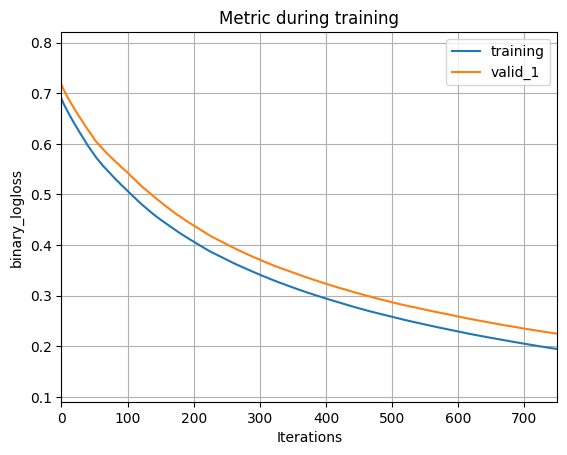

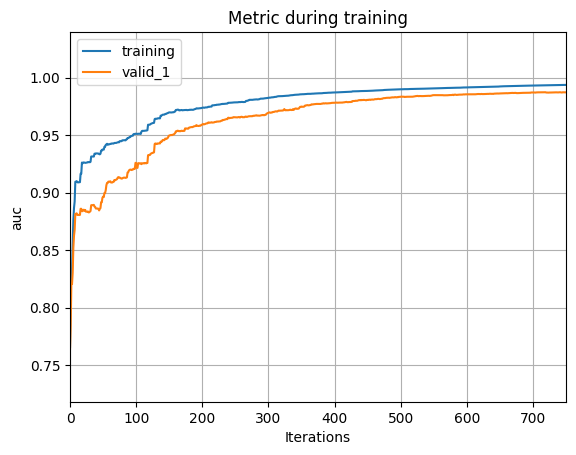

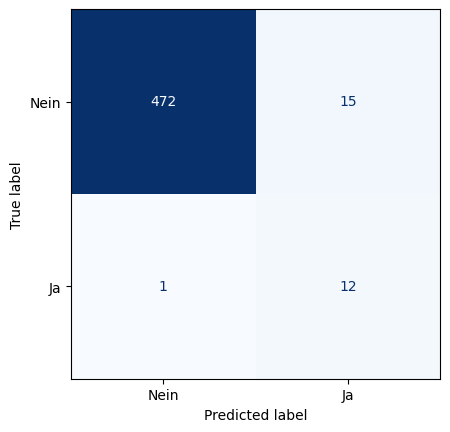

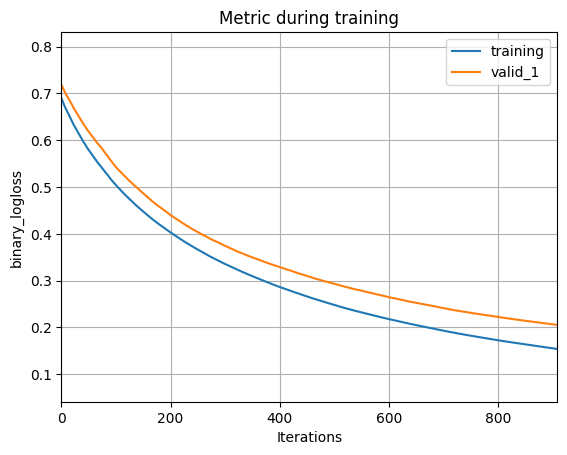

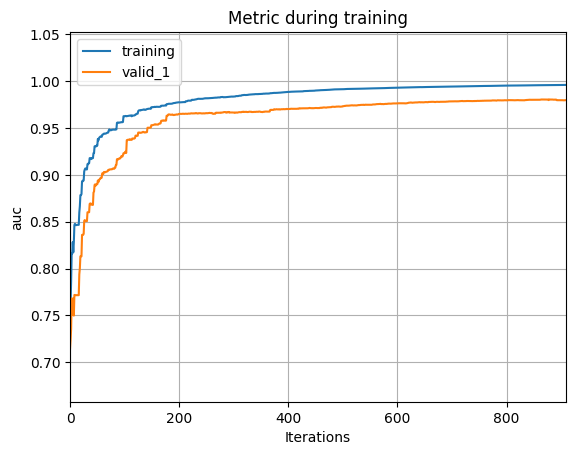

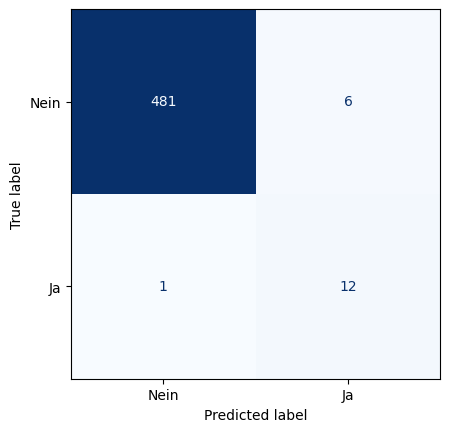

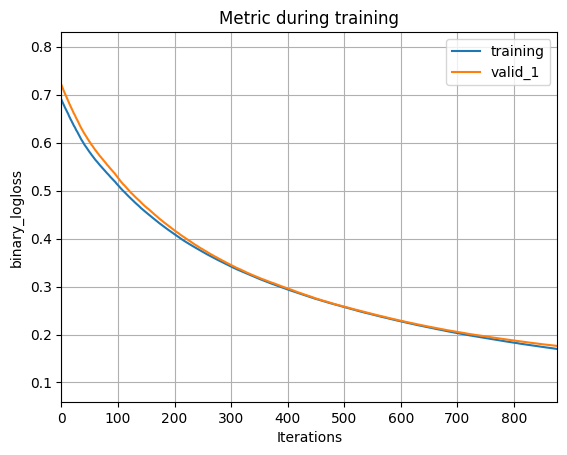

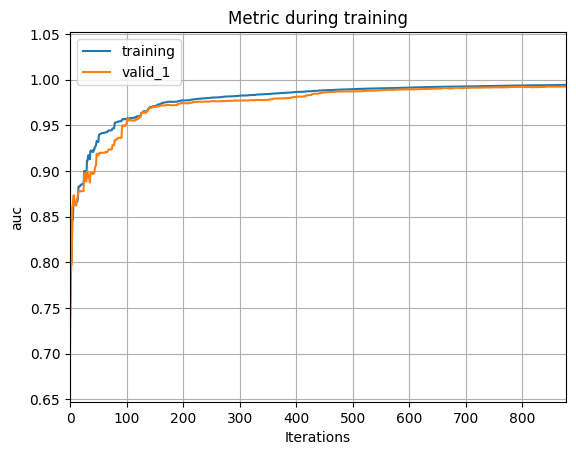

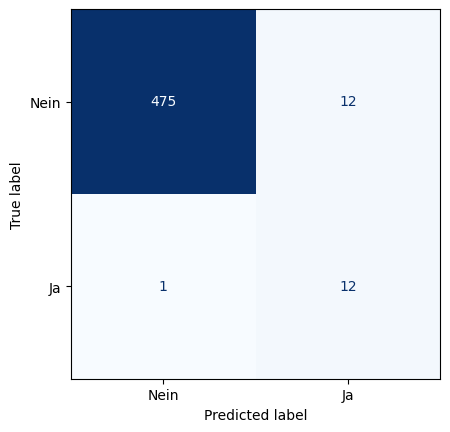

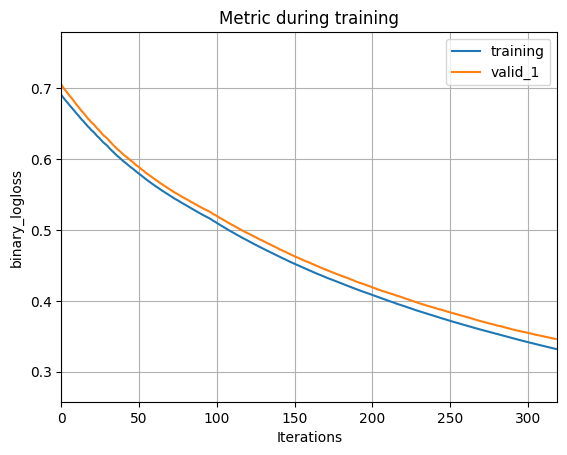

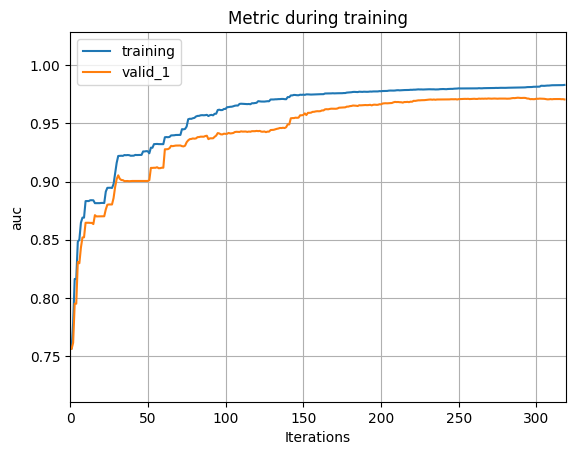

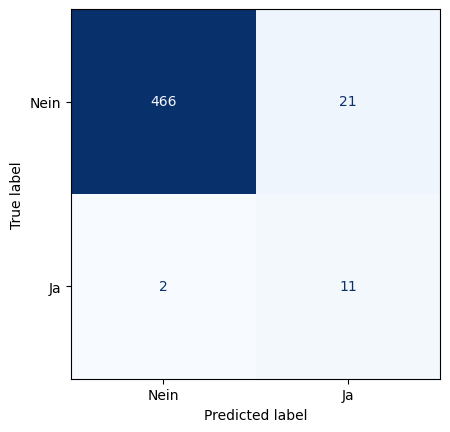

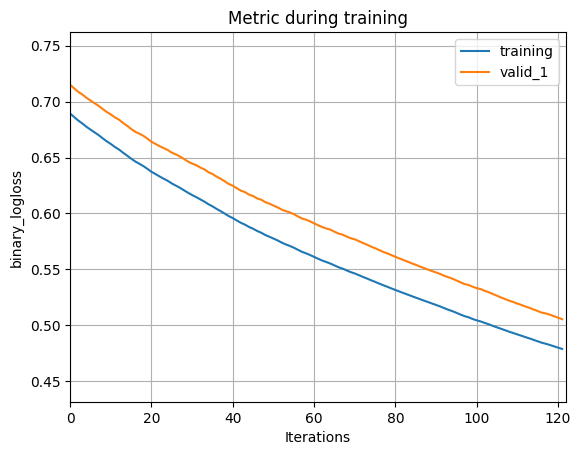

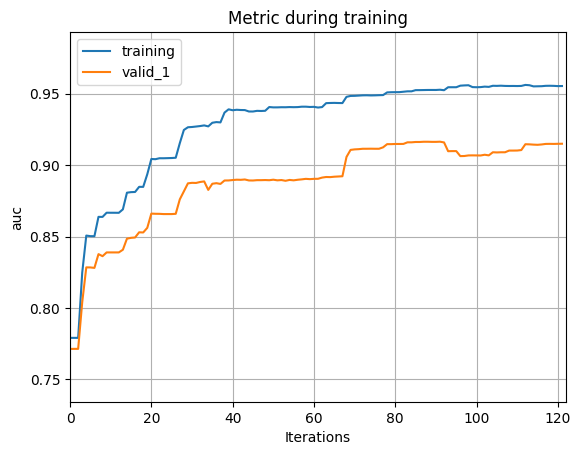

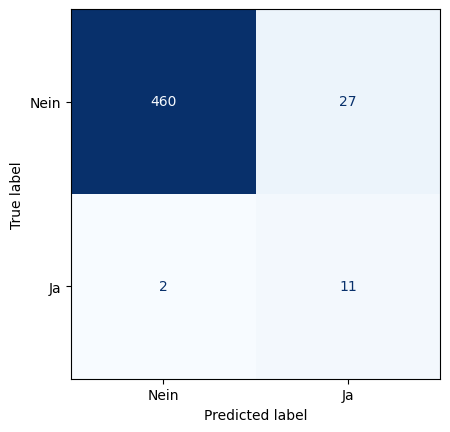

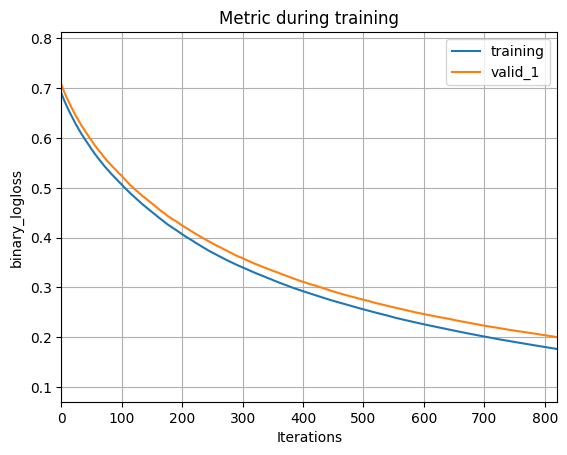

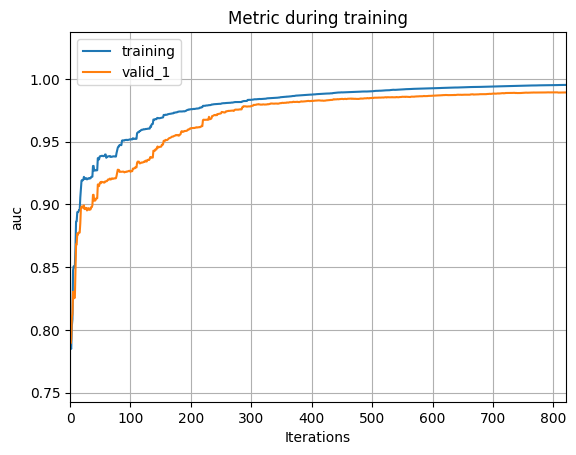

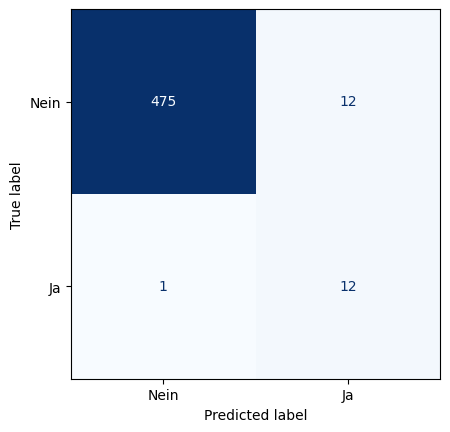

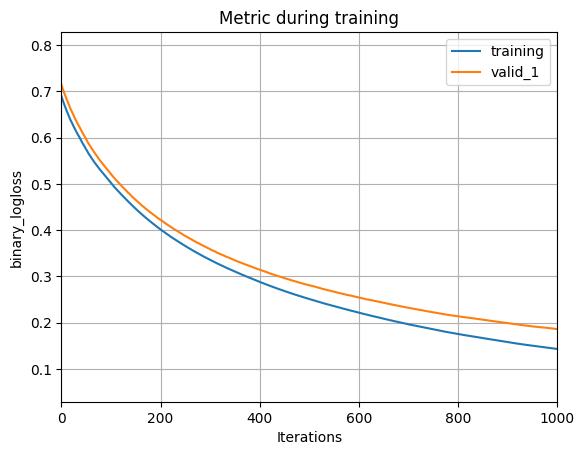

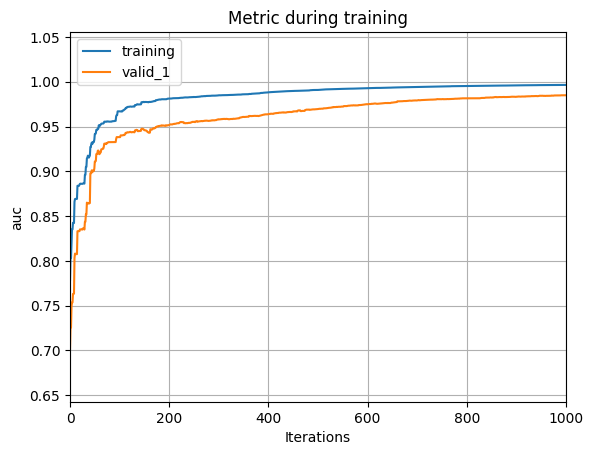

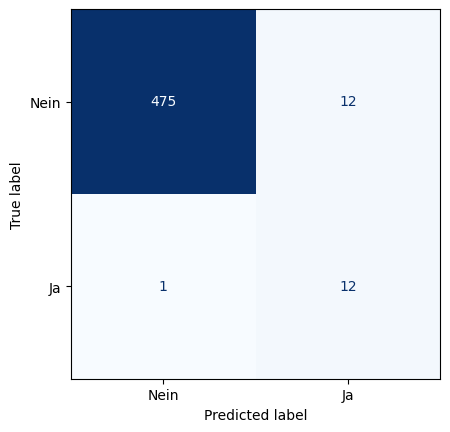

In [14]:
# Split dataset
folder_path = "../data/labeled_data/"
store_model = False
show_preds = False

X_train, y_train, X_test, y_test, features, weight_factor, timestamp, vocab = load_prepare_dataset(folder_path, augmentation=True, kfold=True)

kfold = KFold(n_splits=7, shuffle=True, random_state=42)
evals_list = []

for train_index, val_index in kfold.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    gbm, evals = train_model(X_train_fold, y_train_fold, X_val_fold, y_val_fold, weight_factor)
    evals_list.append(evals)

    y_pred, test_acc = evaluate_model(gbm, X_test, y_test, evals, timestamp)

if show_preds:
    store_predictions(gbm, X_test, y_test, y_pred, features, timestamp)

if store_model:
    store_trained_model(gbm, test_acc, timestamp)